# Исследовательский анализ данных

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Импорт данных

**DataFrame**

In [4]:
df = pd.read_csv('/datasets/faces/labels.csv')
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


**Images**

In [5]:
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25) 
datagen_flow = datagen.flow_from_dataframe( 
    dataframe=df,
    directory='/datasets/faces/final_files', # папка, в которой хранится датасет 
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150), # к какому размеру приводить изображения 
    batch_size=16, # размер батча 
    class_mode=None, # в каком виде выдавать метки классов 
    shuffle=False,
    subset="training",
    seed=12345) # фиксируем генератор random

Found 5694 validated image filenames.


## Исследовательский анализ данных

**Размер выборки**

In [6]:
print(df.shape)

(7591, 2)


In [7]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


**График распределения возраста в выборке**

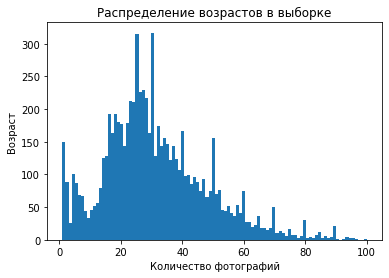

In [8]:
ax = df['real_age'].plot(kind='hist',bins=100, title='Распределение возрастов в выборке')
ax.set_xlabel("Количество фотографий")
ax.set_ylabel("Возраст");

**Примеры фотографий**

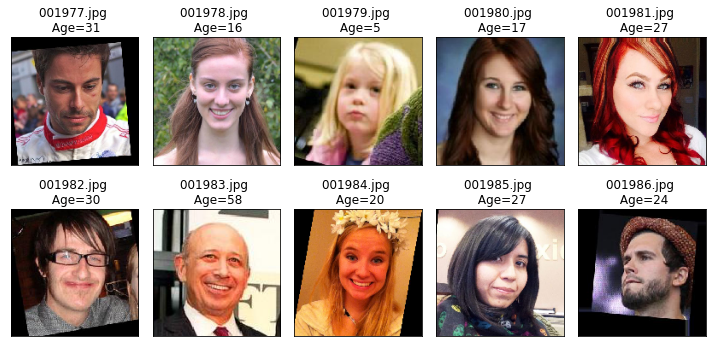

In [14]:
data = next(datagen_flow)

# выводим 10 изображений
fig = plt.figure(figsize=(10,5))
for i in range(10):
    # имя файла
    filename = datagen_flow.filenames[(datagen_flow.batch_index -1) * datagen_flow.batch_size + i]
    age = df.loc[df['file_name'] == filename]['real_age']
    string = f'{filename} \n Age={int(age)}'
    fig.add_subplot(2, 5, i+1)
    plt.imshow((data[i]* 255).astype(np.uint8))
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.title(string)
    plt.tight_layout()

**Промежуточные выводы**

- Количество фотографий в датасете - 7591 шт
- Для каждого фото в datafame из `labels.csv` указан возраст человека
- Распределение возрастов в датасете - похоже на нормальное, однако виден хвост в правую сторону (увеличение возраста), также есть локальные всплески в круглых значниях возраста. Это следует из характера определения возвраста человека на фотографии в датасете - возраст устанавливался голосованием, люди более склонны указыввать круглое значение возраста. 
- Большинство фотографий - цветные
- Почти все фотографии сориентированы правильно, без поворотов, лицо в центре
- На некоторых фоторафиях лица отсутстувуют. Например, на 000100.jpg изображена кровать. 


- Для обучения сети достаточно подгружать фото в размере 150x150x3 - при таком разрешении лица хорошо различимы, однако используем оригинальное разрешение, на котором предобучены веса нейросети - 224х224
- Для приближения к реальным условиям (фотографирование на кассе) можно добавить некоторые аугментации изображений:
    - Flip по горизонтали
    - Поворот изображений в пределах 10 градусов
- Потребуется применить сверточную нейросеть, например с архитектурой LeNet или ResNet
- Поскольку работаем с задачей регрессии - в последнем слое нейросети будет 1 нейрон, активация - ReLu
- Потребуется несколько эпох в обучении

## Код модели определения возраста по фотографии

In [8]:

from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    Conv2D,
    Flatten,
    Dense,
    AvgPool2D,
    MaxPool2D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd

# ------------------------------------------------------------------


def load_train(path):

    df = pd.read_csv(path + "labels.csv")

    datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=10,
    )

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + "final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        shuffle=False,
        subset="training",
        seed=12345,
    )

    return train_datagen_flow


# ------------------------------------------------------------------


def load_test(path):

    df = pd.read_csv(path + "labels.csv")

    datagen = ImageDataGenerator(rescale=1 / 255.0, validation_split=0.25)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + "final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=16,
        class_mode="raw",
        shuffle=False,
        subset="validation",
        seed=12345,
    )

    return test_datagen_flow


# ------------------------------------------------------------------


def create_model(input_shape):

    optimizer = Adam(lr=0.0005)
    backbone = ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation="relu"))

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model


# ------------------------------------------------------------------


def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=40,
    steps_per_epoch=None,
    validation_steps=None,
):

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model



## Вывод модели

    Found 5694 validated image filenames.
    Found 1897 validated image filenames.

    Train for 356 steps, validate for 119 steps

    Epoch 1/40
    356/356 - 116s - loss: 234.8777 - mae: 11.6290 - val_loss: 4873.8790 - val_mae: 67.6650
    Epoch 2/40
    356/356 - 92s - loss: 158.5876 - mae: 9.6354 - val_loss: 368.6217 - val_mae: 14.3860
    Epoch 3/40
    356/356 - 92s - loss: 139.6507 - mae: 9.0788 - val_loss: 160.9339 - val_mae: 9.4293
    Epoch 4/40
    356/356 - 94s - loss: 118.8874 - mae: 8.2884 - val_loss: 123.2783 - val_mae: 8.6104
    Epoch 5/40
    356/356 - 94s - loss: 107.2143 - mae: 7.8650 - val_loss: 150.7469 - val_mae: 9.3813
    Epoch 6/40
    356/356 - 93s - loss: 93.8432 - mae: 7.4075 - val_loss: 111.5341 - val_mae: 7.9203
    Epoch 7/40
    356/356 - 93s - loss: 90.9162 - mae: 7.2539 - val_loss: 155.0042 - val_mae: 9.0691
    Epoch 8/40
    356/356 - 92s - loss: 79.9535 - mae: 6.8075 - val_loss: 154.9698 - val_mae: 9.2583
    Epoch 9/40
    356/356 - 93s - loss: 72.6384 - mae: 6.4739 - val_loss: 96.8856 - val_mae: 7.4641
    Epoch 10/40
    356/356 - 88s - loss: 69.6107 - mae: 6.3412 - val_loss: 182.8377 - val_mae: 10.3930
    Epoch 11/40
    356/356 - 88s - loss: 60.9715 - mae: 5.9252 - val_loss: 134.1216 - val_mae: 9.3355
    Epoch 12/40
    356/356 - 88s - loss: 59.3347 - mae: 5.9155 - val_loss: 145.5197 - val_mae: 9.3530
    Epoch 13/40
    356/356 - 91s - loss: 56.5845 - mae: 5.7607 - val_loss: 97.0799 - val_mae: 7.3738
    Epoch 14/40
    356/356 - 89s - loss: 49.3309 - mae: 5.4064 - val_loss: 113.6585 - val_mae: 7.8537
    Epoch 15/40
    356/356 - 88s - loss: 46.6180 - mae: 5.2420 - val_loss: 112.7078 - val_mae: 8.1172
    Epoch 16/40
    356/356 - 94s - loss: 42.1427 - mae: 4.9981 - val_loss: 81.5614 - val_mae: 6.7626
    Epoch 17/40
    356/356 - 106s - loss: 39.2405 - mae: 4.8019 - val_loss: 87.9328 - val_mae: 7.2256
    Epoch 18/40
    356/356 - 99s - loss: 37.6388 - mae: 4.7080 - val_loss: 75.3017 - val_mae: 6.4786
    Epoch 19/40
    356/356 - 104s - loss: 34.3465 - mae: 4.5733 - val_loss: 82.2681 - val_mae: 6.6389
    Epoch 20/40
    356/356 - 105s - loss: 33.7713 - mae: 4.4548 - val_loss: 177.1040 - val_mae: 10.3058
    Epoch 21/40
    356/356 - 109s - loss: 33.1135 - mae: 4.4708 - val_loss: 81.3516 - val_mae: 6.8470
    Epoch 22/40
    356/356 - 104s - loss: 29.1102 - mae: 4.1849 - val_loss: 81.3053 - val_mae: 6.6310
    Epoch 23/40
    356/356 - 98s - loss: 27.7408 - mae: 4.0188 - val_loss: 84.3843 - val_mae: 6.8295
    Epoch 24/40
    356/356 - 102s - loss: 25.8685 - mae: 3.9093 - val_loss: 85.0093 - val_mae: 6.9699
    Epoch 25/40
    356/356 - 102s - loss: 29.7499 - mae: 4.1654 - val_loss: 78.4704 - val_mae: 6.5112
    Epoch 26/40
    356/356 - 103s - loss: 26.0079 - mae: 3.9505 - val_loss: 79.5515 - val_mae: 6.6675
    Epoch 27/40
    356/356 - 103s - loss: 23.1732 - mae: 3.7218 - val_loss: 78.1983 - val_mae: 6.5162
    Epoch 28/40
    356/356 - 102s - loss: 25.6772 - mae: 3.8749 - val_loss: 105.3142 - val_mae: 7.8646
    Epoch 29/40
    356/356 - 101s - loss: 23.2033 - mae: 3.7294 - val_loss: 94.7622 - val_mae: 7.1567
    Epoch 30/40
    356/356 - 95s - loss: 18.9722 - mae: 3.3676 - val_loss: 96.5360 - val_mae: 7.2487
    Epoch 31/40
    356/356 - 106s - loss: 19.3390 - mae: 3.3783 - val_loss: 82.7009 - val_mae: 6.8155
    Epoch 32/40
    356/356 - 107s - loss: 20.0623 - mae: 3.4427 - val_loss: 103.1460 - val_mae: 7.7361
    Epoch 33/40
    356/356 - 101s - loss: 17.0852 - mae: 3.1794 - val_loss: 86.7913 - val_mae: 7.0042
    Epoch 34/40
    356/356 - 95s - loss: 15.7283 - mae: 3.0807 - val_loss: 81.0757 - val_mae: 6.8919
    Epoch 35/40
    356/356 - 95s - loss: 15.7760 - mae: 3.0866 - val_loss: 108.7424 - val_mae: 7.7769
    Epoch 36/40
    356/356 - 88s - loss: 15.7408 - mae: 3.0790 - val_loss: 82.1832 - val_mae: 6.6211
    Epoch 37/40
    356/356 - 88s - loss: 14.4732 - mae: 2.9460 - val_loss: 77.3816 - val_mae: 6.5985
    Epoch 38/40
    356/356 - 88s - loss: 16.4393 - mae: 3.1212 - val_loss: 78.4916 - val_mae: 6.6296
    Epoch 39/40
    356/356 - 90s - loss: 13.9513 - mae: 2.8723 - val_loss: 73.8959 - val_mae: 6.4084
    Epoch 40/40
    356/356 - 92s - loss: 13.9079 - mae: 2.8482 - val_loss: 78.1460 - val_mae: 6.6374
     
    119/119 - 10s - loss: 78.1460 - mae: 6.6374
    Test MAE: 6.6374

## Общий вывод

**Импорт и анализ данных:**
- Количество фотографий в датасете - 7591 шт
- Для каждого фото в datafame из `labels.csv` указан возраст человека
- Распределение возрастов в датасете - похоже на нормальное, однако виден хвост в правую сторону (увеличение возраста), также есть локальные всплески в круглых значниях возраста. Это следует из характера определения возвраста человека на фотографии в датасете - возраст устанавливался голосованием, люди более склонны указыввать круглое значение возраста. 
- Большинство фотографий - цветные
- Почти все фотографии сориентированы правильно, без поворотов, лицо в центре
- На некоторых фоторафиях лица отсутстувуют. Например, на 000100.jpg изображена кровать. 


- Для обучения сети достаточно подгружать фото в размере 150x150x3 - при таком разрешении лица хорошо различимы, однако используем оригинальное разрешение, на котором предобучены веса нейросети - 224х224
- Для приближения к реальным условиям (фотографирование на кассе) можно добавить некоторые аугментации изображений:
    - Flip по горизонтали
    - Поворот изображений в пределах 10 градусов
- Потребуется применить сверточную нейросеть, например с архитектурой LeNet или ResNet
- Поскольку работаем с задачей регрессии - в последнем слое нейросети будет 1 нейрон, активация - ReLu
- Потребуется несколько эпох в обучении

**Анализ результатов обучения модели:**
- Исходные данные разделены на обучающую и тестовую выборку в пропорции 75:25
- За основу была взята структура ResNet50, т.к. со структурой LeNet не удалось получить приемлемую точность
- Отличие от стандартной архитектуры - выходной слой модели состоит GlobalAveragePooling2D() и из полносвязного слоя с 1 нейроном (т.к. задача регрессии) 
- Первоначальные настройки весов - `imagenet`, предобученные слои не заморожены
- Поскольку данные для обучения подгружаются с аугментациями, потребовалось 40 эпох для получения хорошего результата (MAE < 7.0), при этом уже на 6й эпохе модель вышла на минимально приемлемую точность (MAE < 8.0)
- По итогам обучения модели значительного переобучения нет, т.к. разница MAE между обучающей и тестовой выборкой не значительна (Train mae: 2.8482 Test MAE: 6.6374)
- Можно увеличить количество эпох и, вероятно, достигнуть лучших результатов
- В итоге обучения удалось выйти на **MAE = 6.6374 на тестовой выборке**, что соответствует условиям задания